# Signal Selection


In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

In [2]:
# load data
def load_wav(wav_path):
    samplerate, data = wavfile.read(wav_path)
    #start=int(len(data)*0.1)
    #end=int(len(data)*0.9)
    #data=data[start:end]
    data=data/np.max(data)
    return samplerate, data

In [3]:
# preprocessing(remove spike and normalization)
def pre_process(data):
    R=4
    data=data/np.std(data)
    abs_data_sorted=-np.sort(-1*np.abs(data))# sort in descending order
    TH=np.mean(abs_data_sorted[0:int(0.1*len(data))])
    for i in range(0,len(data)):
        if np.abs(data[i]) > R*TH:
            #print(f"replace {i}")
            data[i] = R*TH
    data=data/np.std(data)
    return data

In [4]:
# data path
clean_pcg_path='./data/clean_pcg/New_N_001.wav'

In [5]:
# load data and data overview
sample_rate, data = load_wav(clean_pcg_path)
#data = pre_process(data)

In [6]:
def get_signal_power(s):
    return np.mean(s**2)
def get_noise_model(func,N,target_snr):
    signal_power = get_signal_power(data)
    sig_avg_db = 10 * np.log10(signal_power)
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    noise_volts = np.random.normal(0, np.sqrt(noise_avg_watts), N)
    white_noise=np.fft.rfft(noise_volts)
    S=func(np.fft.rfftfreq(N))
    S=S/np.sqrt(np.mean(S**2) + 1e-10)
    return np.fft.irfft(white_noise*S)

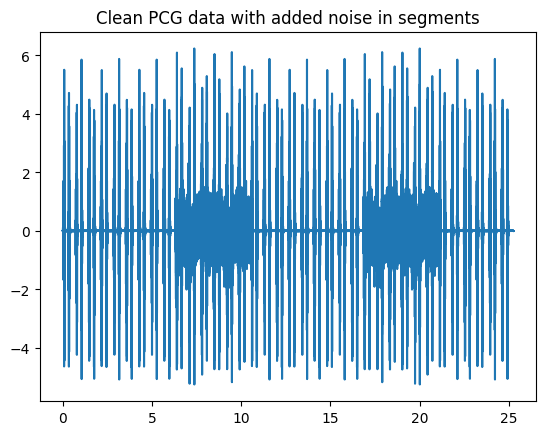

In [7]:
target_snr_db = 5
pink_spec=lambda f: 1 / np.where(f == 0, float('inf'), np.sqrt(f))
N=data.shape[0]
pinkNoise=get_noise_model(pink_spec,N,target_snr_db)
noised_data=data+np.pad(pinkNoise,(0,len(data)-len(pinkNoise)),'constant',constant_values=0)
data_1=np.tile(data,3)
data_1=np.append(data_1,noised_data)
data_1=np.append(data_1,noised_data)
data_1=np.tile(data_1,2)
data=np.append(data_1,np.tile(data,2))
data = pre_process(data)
data=data[::2]
sample_rate=sample_rate/2
plt.plot(np.linspace(0, len(data)/sample_rate, len(data)),data)
plt.title('Clean PCG data with added noise in segments')
plt.savefig("origin_data.png")
plt.show()

In [8]:
# compute time-varying auto correlation
def get_caf(data,alpha,tau):
    return np.mean(data*np.conj(np.roll(data,tau))*np.exp(-2j*np.pi*alpha*np.arange(data.shape[0])))

In [9]:
# perform fourier transform to get cyclic spectral density(CSD),integrate to get cycle frequency spectral density(CFSD)
def get_cfsd(alphas,data):
    CAF = np.zeros((len(alphas), len(taus)), dtype=complex)
    CFSD=np.zeros(len(alphas),dtype=float)
    for j in range(len(alphas)):
        for i in range(len(taus)):
            CAF[j, i] = get_caf(data,alphas[j],taus[i])
        csd=np.fft.fft(CAF[j])
        CFSD[j]=np.sum(np.abs(csd))
    return CFSD

In [10]:
# calculate quality index based on CFSD
def get_q_index(cfsd):
    return np.max(cfsd[1:])/np.sum(cfsd[1:])

In [11]:
# siding window to compute quality index for the signal
# window size 8s, step 0.1s
data_q_index=[]
window_dur=8
window_length=int(window_dur*sample_rate)
step_dur=0.1
step_length=int(step_dur*sample_rate)

cf_low=0
cf_high=1.5
alphas = np.arange(cf_low,cf_high, 0.2)
taus = np.arange(-1000, 1000)
flag_50000=0
for i in range(0,len(data)-window_length+1,step_length):
    data_seg=data[i:i+window_length]
    CFSD = get_cfsd(alphas,data_seg)
    q_index = get_q_index(CFSD)
    data_q_index.append(q_index)
plt.plot(data_q_index)
np.savetxt("data_q_index", data_q_index)

KeyboardInterrupt: 

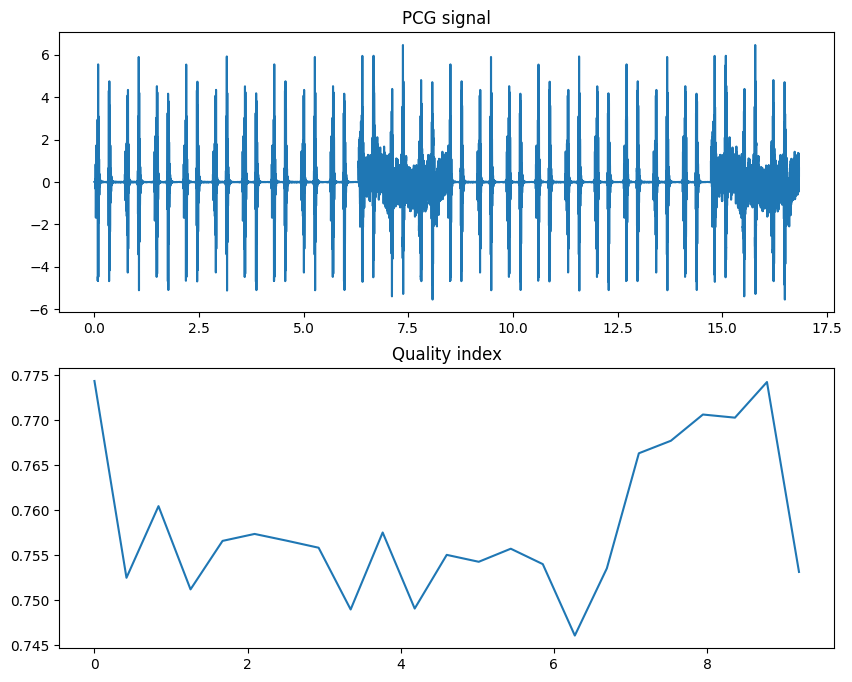

In [24]:
# outcome overview
fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # 2x2 grid of subplots

# Plot data in each subplot
axes[0].plot(np.linspace(0, len(data)/sample_rate, len(data)), data)
axes[0].set_title("PCG signal")

axes[1].plot(np.linspace(0, len(data_q_index)*step_dur, len(data_q_index)), data_q_index)
axes[1].set_title("Quality index")
plt.savefig("output.png")

In [24]:
def duplicate_elements(arr, n):
    return [element for element in arr for _ in range(n)]

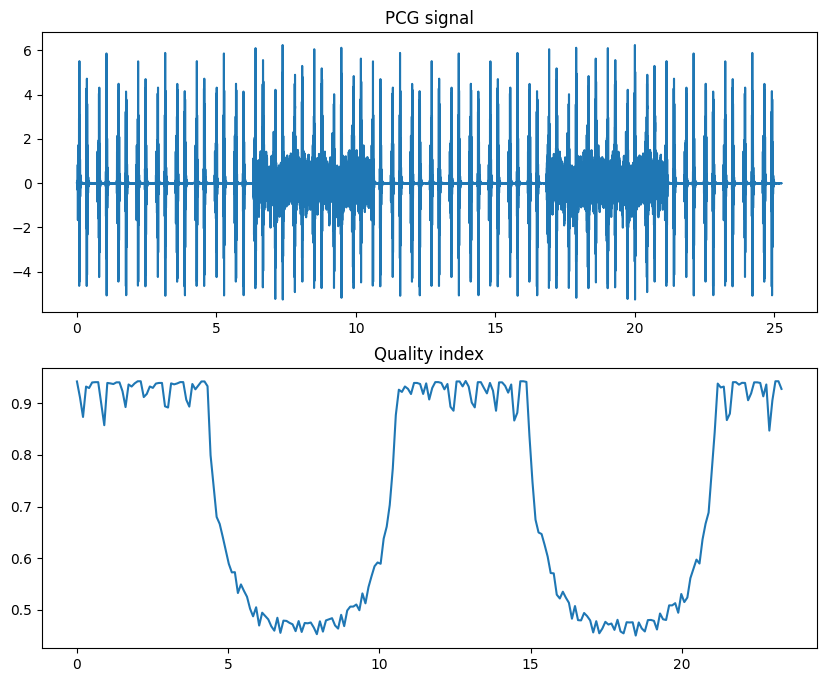

In [37]:
q_index=np.loadtxt('./data_q_index_2_window.txt')
q_index_extend=np.array(duplicate_elements(q_index,step_length))
q_index_padded = np.pad(q_index_extend, (0, len(data) - len(q_index_extend)), constant_values=np.nan)
# outcome overview
fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # 2x2 grid of subplots

# Plot data in each subplot
axes[0].plot(np.linspace(0, len(data)/sample_rate, len(data)), data)
axes[0].set_title("PCG signal")

axes[1].plot(np.linspace(0, len(q_index)*step_dur, len(q_index)),q_index)
axes[1].set_title("Quality index")
plt.savefig("output.png")

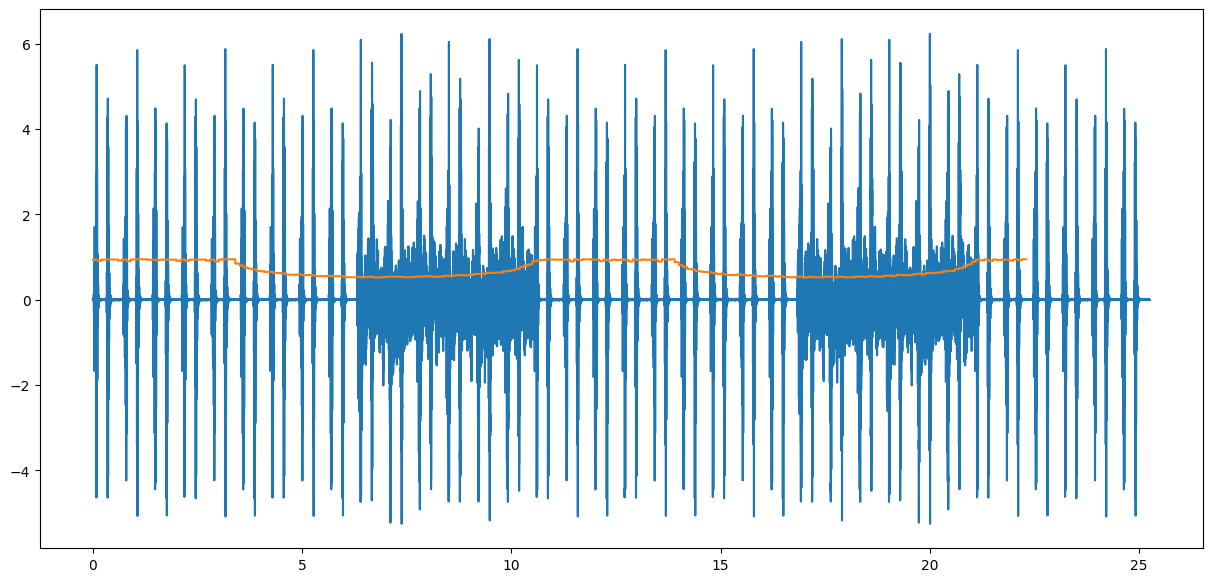

In [31]:
plt.figure(figsize=(15, 7))
plt.plot(np.linspace(0, len(data)/sample_rate, len(data)), data)
plt.plot(np.linspace(0, len(data)/sample_rate, len(data)), q_index_padded)
plt.show()

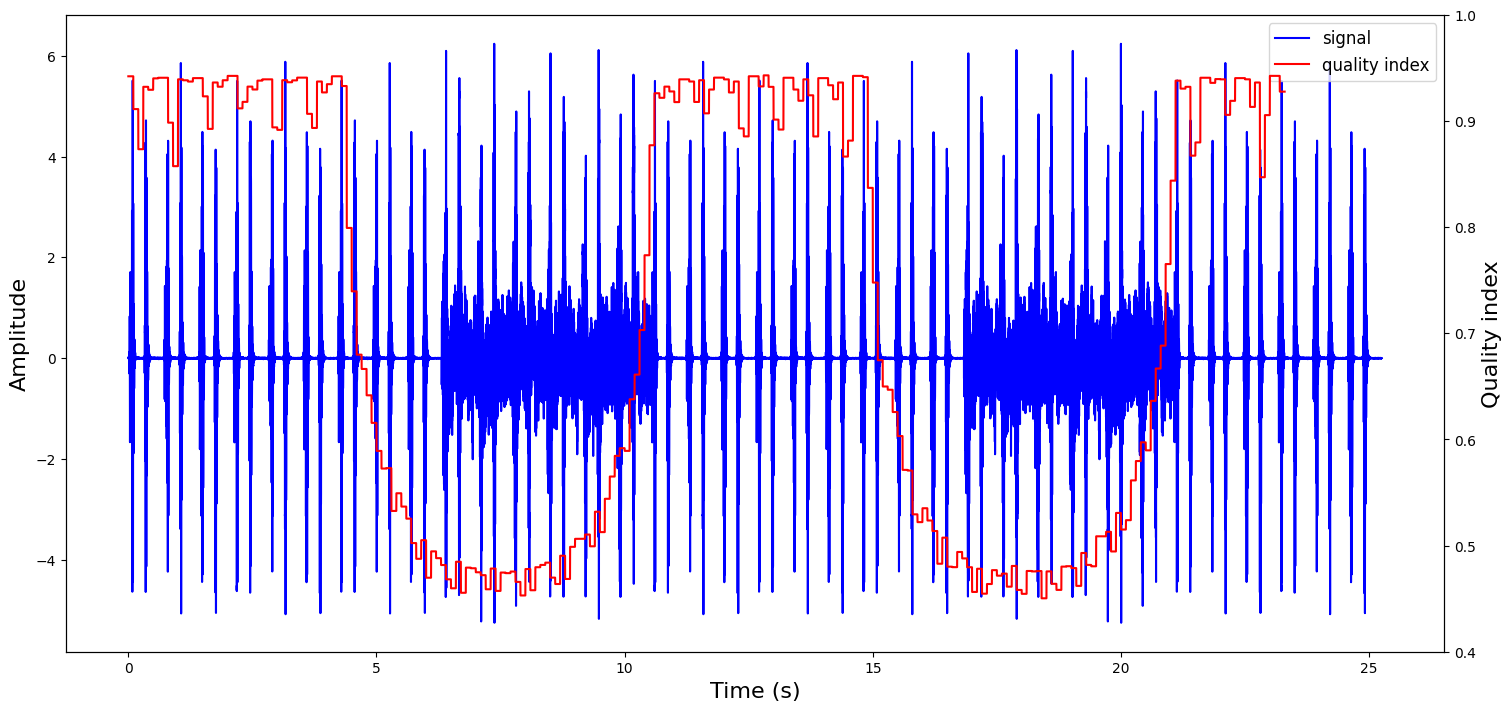

In [41]:
fig, host = plt.subplots(figsize=(15,7), layout='constrained')


ax2 = host.twinx()



#host.set_ylim(0, 2)
ax2.set_ylim(0.4, 1)


host.set_xlabel("Time (s)",fontsize=16)
host.set_ylabel("Amplitude",fontsize=16)
ax2.set_ylabel("Quality index",fontsize=16)





p1 = host.plot(np.linspace(0, len(data)/sample_rate, len(data)), data,    color='blue',label='signal')
p2 = ax2.plot(np.linspace(0, len(data)/sample_rate, len(data)), q_index_padded, color='red', label="quality index")


host.legend(handles=p1+p2, loc='best',fontsize=12)
plt.savefig("output.png")
plt.show()


#host.yaxis.label.set_color(p1[0].get_color())
#ax2.yaxis.label.set_color(p2[0].get_color())


# For professional typesetting, e.g. LaTeX, use .pgf or .pdf
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=300)'
#plt.savefig("pyplot_multiple_y-axis.pdf", bbox_inches='tight')

In [28]:
print(q_index.shape)
print(data.shape)
print(q_index_extend.shape)

(223,)
(101022,)
(89200,)
